In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [71]:
df=pd.read_csv("/content/train.csv")
X_test=pd.read_csv('/content/test .csv')
print(X_test.head())
df

      id  person_age  person_income person_home_ownership  person_emp_length  \
0  58645          23          69000                  RENT                3.0   
1  58646          26          96000              MORTGAGE                6.0   
2  58647          26          30000                  RENT                5.0   
3  58648          33          50000                  RENT                4.0   
4  58649          26         102000              MORTGAGE                8.0   

         loan_intent loan_grade  loan_amnt  loan_int_rate  \
0    HOMEIMPROVEMENT          F      25000          15.76   
1           PERSONAL          C      10000          12.68   
2            VENTURE          E       4000          17.19   
3  DEBTCONSOLIDATION          A       7000           8.90   
4    HOMEIMPROVEMENT          D      15000          16.32   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.36                         N                         

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0


In [72]:
df.isnull().sum()

,0
id,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_percent_income,0


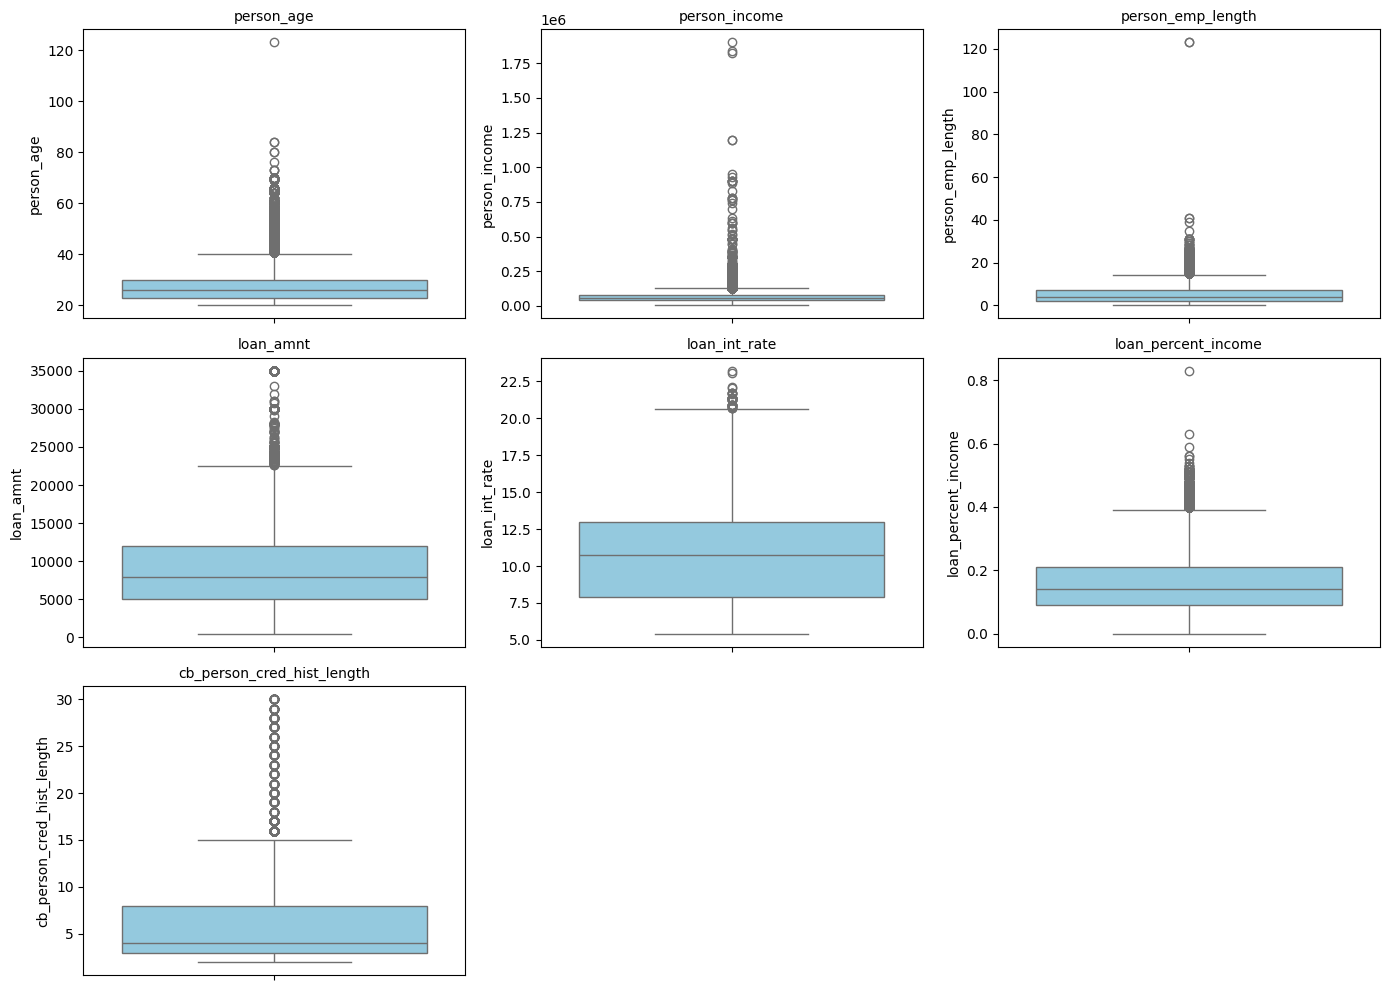

In [49]:
#plot the boxplot to dtect the outliers present or not in numerical columns
# List of numerical columns
numerical_columns = [
    "person_age",
    "person_income",
    "person_emp_length",
    "loan_amnt",
    "loan_int_rate",
    "loan_percent_income",
    "cb_person_cred_hist_length",
]

# Plot settings
plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[column], color="skyblue")
    plt.title(column, fontsize=10)
    plt.xlabel("")

plt.tight_layout()
plt.show()

In [50]:
# Function to remove outliers using the IQR method
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)  # 25th percentile
        Q3 = df[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR  # Lower bound
        upper_bound = Q3 + 1.5 * IQR  # Upper bound

        # Filter rows within bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers
cleaned_df = remove_outliers_iqr(df, numerical_columns)

# Display results
print("Original DataFrame:")
print(df)
print("\nCleaned DataFrame (Outliers Removed):")
print(cleaned_df)

Original DataFrame:
          id  person_age  person_income person_home_ownership  \
0          0          37          35000                  RENT   
1          1          22          56000                   OWN   
2          2          29          28800                   OWN   
3          3          30          70000                  RENT   
4          4          22          60000                  RENT   
...      ...         ...            ...                   ...   
58640  58640          34         120000              MORTGAGE   
58641  58641          28          28800                  RENT   
58642  58642          23          44000                  RENT   
58643  58643          22          30000                  RENT   
58644  58644          31          75000              MORTGAGE   

       person_emp_length loan_intent loan_grade  loan_amnt  loan_int_rate  \
0                    0.0   EDUCATION          B       6000          11.49   
1                    6.0     MEDICAL         

In [51]:
print(cleaned_df['person_home_ownership'].unique())
print(cleaned_df['loan_intent'].unique())
print(cleaned_df['loan_grade'].unique())
print(cleaned_df['cb_person_default_on_file'].unique())

['OWN' 'RENT' 'MORTGAGE' 'OTHER']
['MEDICAL' 'PERSONAL' 'VENTURE' 'EDUCATION' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
['C' 'A' 'B' 'D' 'E' 'F' 'G']
['N' 'Y']


In [52]:
# To change the columns of person_home_ownership,loan_intent , loan_grade,cb_person_default_on_file to give the label encoding
columns_to_encode = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
le = preprocessing.LabelEncoder()
for col in columns_to_encode:
    cleaned_df[col] = le.fit_transform(cleaned_df[col])
    X_test[col]=le.fit_transform(X_test[col])

In [53]:
for col in columns_to_encode:
    print(cleaned_df[col].unique())

[2 3 0 1]
[3 4 5 1 0 2]
[2 0 1 3 4 5 6]
[0 1]


In [41]:
cleaned_df.corr()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,1.000000,0.002055,-0.003951,-0.000735,-0.001093,-0.006054,-0.002681,-0.008761,-0.003477,-0.006542,0.001202,0.007621,-0.010616
person_age,0.002055,1.000000,0.103078,-0.050601,0.059795,0.036342,0.005183,0.040278,0.001217,-0.031357,0.004101,0.792443,-0.008931
person_income,-0.003951,0.103078,1.000000,-0.346490,0.211713,-0.006000,-0.095154,0.341886,-0.097649,-0.340387,-0.049739,0.080543,-0.208918
person_home_ownership,-0.000735,-0.050601,-0.346490,1.000000,-0.305700,-0.003538,0.192026,-0.101951,0.213604,0.147163,0.101814,-0.048657,0.188139
person_emp_length,-0.001093,0.059795,0.211713,-0.305700,1.000000,0.011923,-0.097153,0.093952,-0.105309,-0.063687,-0.057810,0.066199,-0.107833
loan_intent,-0.006054,0.036342,-0.006000,-0.003538,0.011923,1.000000,-0.005237,0.002936,-0.006881,0.007999,-0.006170,0.030579,-0.047957
loan_grade,-0.002681,0.005183,-0.095154,0.192026,-0.097153,-0.005237,1.000000,0.079327,0.935281,0.129732,0.556143,-0.003298,0.396223
loan_amnt,-0.008761,0.040278,0.341886,-0.101951,0.093952,0.002936,0.079327,1.000000,0.078993,0.694007,0.012818,0.036948,0.101633
loan_int_rate,-0.003477,0.001217,-0.097649,0.213604,-0.105309,-0.006881,0.935281,0.078993,1.000000,0.130181,0.504126,-0.004002,0.344195
loan_percent_income,-0.006542,-0.031357,-0.340387,0.147163,-0.063687,0.007999,0.129732,0.694007,0.130181,1.000000,0.037865,-0.019945,0.302228


In [54]:
cleaned_df['loan_status'].value_counts()

,count
loan_status,
0,42462
1,6265


In [55]:
X_train=cleaned_df.drop('loan_status',axis=1)
y_train=cleaned_df['loan_status']
counter = Counter(y_train)
print('Before', counter)

# oversampling the train dataset using SMOTE
smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After', counter)
print('X  shape',X_train_sm.shape)
print('y Shape',y_train_sm.shape)

Before Counter({0: 42462, 1: 6265})
After Counter({0: 42462, 1: 42462})
X  shape (84924, 12)
y Shape (84924,)


In [56]:

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
x_train_scaler = scaler.fit_transform(X_train_sm)
X_test_scaler=scaler.fit_transform(X_test)
x_train_scaler

array([[-1.72070118, -1.06844043,  0.12067824, ..., -1.15715633,
        -0.38950594, -1.05408858],
       [-1.72064199,  0.85452526, -1.12449309, ...,  0.30892754,
        -0.38950594,  2.10640476],
       [-1.7205828 ,  1.12923465,  0.76157525, ..., -0.10995357,
        -0.38950594,  0.13109643],
       ...,
       [-0.18335704, -1.06844043, -1.31996668, ...,  0.35104308,
        -0.38950594, -0.65902691],
       [ 1.65224595,  0.85452526, -1.86276066, ..., -0.13857131,
        -0.38950594,  0.52615809],
       [ 0.12626631, -0.24431228,  0.02912152, ..., -0.19109384,
        -0.38950594, -0.65902691]])

In [58]:
model = LogisticRegression()
model.fit(x_train_scaler, y_train_sm)
y_pred =model.predict(X_test_scaler)

In [59]:
y_pred

array([1, 0, 1, ..., 0, 1, 1])

In [66]:
# Ensure X_test has the 'id' column (assuming the dataset originally had it)
print(X_test.head())
X_test_id = X_test.copy()
# Create DataFrame with id and y_test
test_results = pd.DataFrame({'id': X_test_id['id'], 'loan_status': y_pred})

test_results

      id  person_age  person_income person_home_ownership  person_emp_length  \
0  58645          23          69000                  RENT                3.0   
1  58646          26          96000              MORTGAGE                6.0   
2  58647          26          30000                  RENT                5.0   
3  58648          33          50000                  RENT                4.0   
4  58649          26         102000              MORTGAGE                8.0   

         loan_intent loan_grade  loan_amnt  loan_int_rate  \
0    HOMEIMPROVEMENT          F      25000          15.76   
1           PERSONAL          C      10000          12.68   
2            VENTURE          E       4000          17.19   
3  DEBTCONSOLIDATION          A       7000           8.90   
4    HOMEIMPROVEMENT          D      15000          16.32   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.36                         N                         

,id,loan_status
0,58645,1
1,58646,0
2,58647,1
3,58648,1
4,58649,1
...,...,...
39093,97738,1
39094,97739,0
39095,97740,0
39096,97741,1


In [68]:
# Save to CSV
test_results.to_csv("loan_approval.csv", index=False)